In [426]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve

In [427]:
train_raw = pd.read_csv('LC_TrainingData.csv',low_memory=False)
test_raw = pd.read_csv('LC_TestData.csv',low_memory=False)
train_df = copy.copy(train_raw)
test_df = copy.copy(test_raw)
datasets = [train_df, test_df]
print(train_df.shape,test_df.shape)

(103546, 21) (96779, 22)


In [428]:
def log_cv_score(df):
    X = df.drop(['target'],axis=1)
    y = df['target']

    # stratified cv split to keep inbanaced data distribution same in each fold
    cv = StratifiedShuffleSplit(n_splits=5,random_state=42)
    
    logreg = LogisticRegression(random_state=42)
    score = cross_val_score(logreg, X, y, cv=cv).mean()
    print(score)
    return score

# Data preprocessing

### 1. Target variable

"Loan status" tells if the payments of a loan are in time. 
- ("grace period", "late", "charged off", "default") => the loan is in default
- ("current", "fully paid") => not in default

__Severely inbalanced target variable__: may cause problems, depending on models. Possible solutions: upsampling 

In [429]:
# create target variable 
def create_target(df):
    df['target'] = 1 # default
    df.loc[(df['loan_status']=='Current') |  # not default
                 (df['loan_status']=='Fully Paid'),'target'] = 0  
    df = df.drop('loan_status',axis=1)
    return df

train_df = create_target(train_df)
test_df = create_target(test_df)

Text(0, 0.5, 'Count')

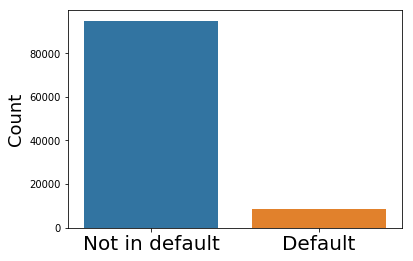

In [430]:
#plt.figure(figsize=(7,8))
sns.countplot(train_df['target']);
plt.xlabel('')
plt.xticks(ticks=[0,1],labels=['Not in default','Default'],size=20)
plt.ylabel('Count',size=18)

Text(0, 0.5, 'Count')

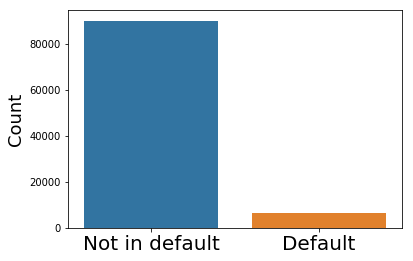

In [431]:
#plt.figure(figsize=(7,8))
sns.countplot(test_df['target']);
plt.xlabel('')
plt.xticks(ticks=[0,1],labels=['Not in default','Default'],size=20)
plt.ylabel('Count',size=18)

### 2. Missing values
1. 'desc' column is 100% NA , simply remove it. 
2. 'mths_since_last_delinq' NA can be interpreted as last default case is very long time ago, therefore we should fill NA with a very large value. 
3. 'mths_since_last_record' NA can be interpreted as new users with no previous record, therefore fill NA with 0.
4. 'emp_title', 'emp_length' NA can be treated as unemployed, or not provided. Either way, we could fill emp_title as empty string '', emp_length as 0.
5. 'dti' is the ratio of total debt obligations(excluding mortgage and the requested Lending Club loan)/income, it represents the percentage of income that goes to debt payment. dit NA can be permuted with the average/mode dti. Because it's safer and more probable to assume that an applicant's dti is the average/most common dti, than any other extreme values such as 0 or 1. Also there are only 28 missing values, so the mean fills have negalectable impact on the dataset. 
6. there are only 4 'title' NAs, it's safe to fill those NAs with the most common title value. 

__Note that__: for test set, use the value(number/mean/mode) learnt from the training data!

In [432]:
# show missing values
def show_NA(df):
    NAs = pd.concat([np.sum(df.isna()), 
                     (100*np.sum(df.isna())/df.shape[0]).map('{:,.0f}'.format)],
                    axis=1, keys = ['NA count','NA percentage'])
    display(NAs.loc[NAs['NA count']>0].sort_values('NA count',ascending=False))

show_NA(train_df)
show_NA(test_df)

,NA count,NA percentage
desc,103545,100
mths_since_last_record,82466,80
mths_since_last_delinq,47774,46
emp_title,7048,7
emp_length,6877,7
dti,28,0
title,4,0


,NA count,NA percentage
desc,96779,100
mths_since_last_record,77674,80
mths_since_last_delinq,46293,48
emp_title,6892,7
emp_length,6792,7
dti,33,0
zip_code,1,0


In [433]:
# Drop and fill NAs with the same values learnt from train_df
def fill_NA(df):
    df = df.drop('desc',axis=1)
    df['mths_since_last_record'].fillna(0, inplace=True)
    df['mths_since_last_delinq'].fillna(1000, inplace=True)
    df['emp_title'].fillna('', inplace=True)
    df['emp_length'].fillna(0, inplace=True)
    df['dti'].fillna(train_df['dti'].mean(), inplace=True)
    df['title'].fillna(train_df['title'].mode().item(), inplace=True)
    df['zip_code'].fillna(train_df['zip_code'].mode().item(), inplace=True)
    return df

train_df = fill_NA(train_df)
test_df = fill_NA(test_df)

In [434]:
show_NA(train_df)
show_NA(test_df)

,NA count,NA percentage


,NA count,NA percentage


### 3. Numerical variables
1. Extremely long tail left-skewed distributions: annual_inc, dti, delinq_2yrs, open_acc, pub_rec, may need to normalize them or log-scale transform. 
2. 'loan_amnt' and 'installment' are highly correlated, produce their interaction terms might be helpful to capture their correlation. 

In [435]:
num_columns = train_df.select_dtypes(include=['number']).columns
print(f'A total of {num_columns.size} numerical variables: ')
print(list(num_columns))

A total of 11 numerical variables: 
['loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'target']


In [436]:
# Log-scale transform / normalization of numerical values
# done later with sklearn in numpy array

### 4. Categorical variables
1. __emp_title__ has huge amount of possible categories. 
    - Try __one-hot-encoding 'emp_title' vs removing it__    
        - If we do one-hot-encoding with all 38367 unique categories, then the feature space becomes very large and spase. 
        - It may be fine with regularization, but it still increases risks of overfitting. 
    - Create a __new feature: 'management_role'__, which = 1 if loander is in a senior or management position, 0 otherwise.
2. __zip_code__ also has large category space, it's correlated to addr_state, but gives finer geographical proximity information eg. 723xx is close to 724xx. 
    - NO: use numerical value => compare closeness  
    - YES: __one-hot-encoding__ => ignore proximity, only check if particular zip_code is useful for prediction or not. 
        - problem: new zip_code that are not in traning data will not be used because model hasn't learn the parameters for it 
3. !!! __Remove 'earliest_cr_line'__ for now, due to ambiguity 
    - problem: April.00 ==> 1900 or 2000?
4. __'addr_state', 'title', 'home_ownership', 'verification_status', 'term'__ doesn't have order, use __one-hot-encoding__ to convert to numerical values
5. __'emp_length'__ has order and should be changed into __ordinal categorical variable__

In [437]:
# list of columns that are not numerical 
str_columns = train_df.select_dtypes(include=['object']).columns
print(f'A total of {str_columns.size} str categorical variables: ')
# unique category count
unique_value_count = [len(train_df[col].unique()) for col in str_columns]
unique_value_rank = pd.DataFrame(unique_value_count,index = str_columns,
             columns=['Unique value count']).sort_values('Unique value count',ascending=False)
display(unique_value_rank)
display(train_df[unique_value_rank.index].head())

A total of 9 str categorical variables: 


,Unique value count
emp_title,38367
zip_code,868
earliest_cr_line,621
addr_state,49
emp_length,12
title,12
home_ownership,4
verification_status,3
term,2


,emp_title,zip_code,earliest_cr_line,addr_state,emp_length,title,home_ownership,verification_status,term
0,Senior Director,070xx,Oct.99,NJ,9 years,Home improvement,MORTGAGE,Not Verified,60 months
1,Lead machine operator,531xx,Apr.11,WI,6 years,Credit card refinancing,RENT,Not Verified,36 months
2,IT Specialist 6,984xx,Aug.94,WA,10+ years,Credit card refinancing,RENT,Not Verified,36 months
3,Nurse,112xx,Feb.92,NY,2 years,Debt consolidation,RENT,Not Verified,36 months
4,Lead ultrasound technologist,453xx,May.00,OH,10+ years,Debt consolidation,MORTGAGE,Source Verified,36 months


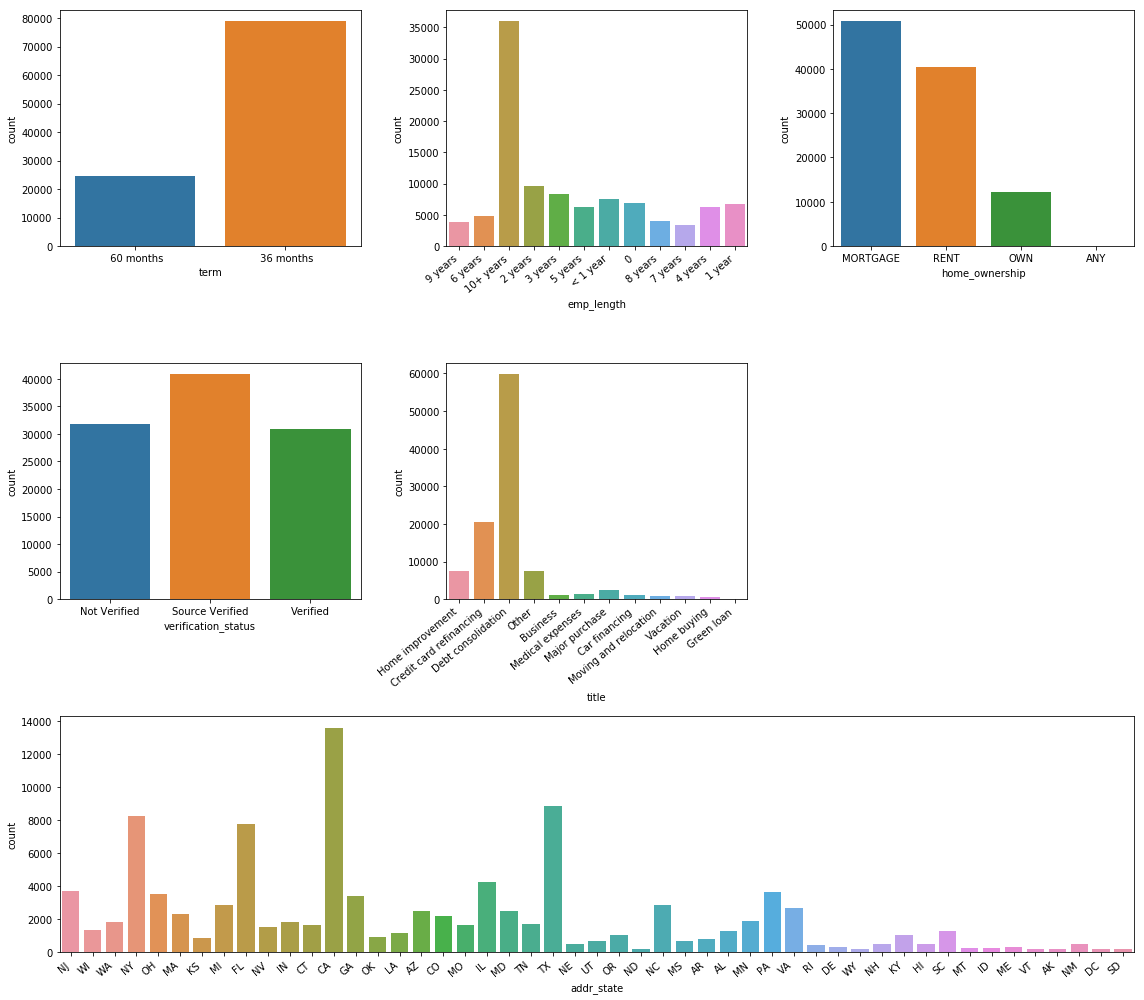

In [438]:
# plot categorical variable distributions

# list of categorical variables with number of categories<=20
cats = [c for c in str_columns if len(train_df[c].unique())<=20]

fig = plt.figure(figsize=(16,14))
for i in range(len(cats)+1):
    
    # make grids
    if i < len(cats):
        ax = fig.add_subplot(331+i)
        variable = train_df[cats[i]]
    else:
        ax = fig.add_subplot(313)
        variable = train_df['addr_state']
    
    s = sns.countplot(variable,ax=ax) 
    if len(variable.unique()) > 4:
        s.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

#### emp_title

In [439]:
# new features: whether the loaner is in a senior or management position
senior_positions = 'manager|supervisor|superviser|owner|president \
                    |senior|director|leader'
# boolean map that check if is senior/manager
is_senior = train_df['emp_title'].str.lower().str.contains(senior_positions)
print('%.2f%%'% (100*train_df[is_senior].shape[0]/train_df.shape[0]),'loaners are in senior or management positions.')
# create new feature
def create_management(df, is_senior=is_senior):
    df['management_role'] = 0
    df.loc[is_senior, 'management_role'] = 1
    df = df.drop('emp_title',axis=1)
    # Test: remove emp_title vs onehotencode
    return df
train_df = create_management(train_df)
test_df = create_management(test_df)

27.17% loaners are in senior or management positions.


#### emp_length

In [440]:
order=[0,'< 1 year','1 years','2 years','3 years','4 years','5 years',
       '6 years','7 years','8 years','9 years','10+ years']
train_df['emp_length'] = pd.Categorical(train_df['emp_length'],
                                        ordered=True,
                                        categories = order)
test_df['emp_length'] = pd.Categorical(test_df['emp_length'],
                                        ordered=True,
                                        categories = order)
train_df['emp_length'] = train_df['emp_length'].cat.codes
test_df['emp_length'] = test_df['emp_length'].cat.codes
#train_df.drop('emp_length', axis=1, inplace=True)

#### regions from states

In [441]:
# Make region lists with state abbres
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

train_df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

train_df['region'] = train_df['addr_state'].apply(finding_regions)
test_df['region'] = test_df['addr_state'].apply(finding_regions)

#### earliest_cr_line

In [442]:
### !!! Not to use 'earliest_cr_line' for now, due to ambiguity !!! ###
### !!! problem: April.00 ==> 1900 or 2000??? ###
def month_diff(date):
    # convert str to datetime 
    then=datetime.strptime(date, '%b.%y')
    now = datetime(2019, 4, 1, 0, 0, 0, 0)
    # time difference between fisrt credit line and now
    diff = now-then 
    # return number of months
    return diff.days/30
train_df['mths_since_1st_credit_line']=train_df['earliest_cr_line'].map(month_diff)
train_df = train_df.drop('earliest_cr_line',axis=1)
test_df['mths_since_1st_credit_line']=test_df['earliest_cr_line'].map(month_diff)
test_df = test_df.drop('earliest_cr_line',axis=1)

#### zip code

In [443]:
# Option 1: one-hot-encoding 
# Option 2: remove 'xx', convert to numerical value
# Option 3: remove it 

# option 1
def zipcode(df, method='onehot'):
    if method == 'onehot':
        onehot = pd.get_dummies(train_df['zip_code'])
        df = df.join(onehot)
        df.drop('zip_code', axis=1, inplace=True)
        
    if method == 'numerical':
        def remove_xx(string):
            string = string[:-2]
            return string
        df['zip_code'] = df['zip_code'].map(remove_xx)
        
    if method == 'remove':
        df.drop('zip_code', axis=1, inplace=True)
    
    return df

# drop it for now! 
train_df.drop('zip_code',axis=1,inplace=True)
test_df.drop('zip_code',axis=1,inplace=True)

#train_df = zipcode(train_df)
#test_df = zipcode(test_df)

#### one hot encoding

In [444]:
col_names = ['addr_state', 'region', 'title', 'home_ownership', 
                   'verification_status','term']

df = pd.concat([train_df,test_df])
onehot = pd.get_dummies(df[col_names])
df.drop(col_names, axis=1, inplace=True)
df = pd.concat([df,onehot],axis=1)
size = train_df.shape[0]
train_df = df[:size]
test_df = df[size:]
print(train_df.shape, test_df.shape)

In [450]:
train_df.shape, test_df.shape

((103546, 91), (96779, 91))

In [451]:
train_df.drop('int_rate',axis=1,inplace=True)
#test_df.drop('int_rate',axis=1,inplace=True)

## Final check and Export to csv

In [452]:
print(train_df.shape)
train_df.head()

(103546, 90)


,annual_inc,delinq_2yrs,dti,emp_length,inq_last_6mths,installment,loan_amnt,management_role,mths_since_1st_credit_line,mths_since_last_delinq,...,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,term_ 36 months,term_ 60 months
0,135000.0,1,6.60,10,0,291.92,14400,1,237.4,11.0,...,0,1,0,0,0,1,0,0,0,1
1,32000.0,0,29.93,7,1,151.06,4500,0,97.4,1000.0,...,0,0,0,0,1,1,0,0,1,0
2,89712.0,0,20.30,11,0,118.53,3600,0,300.3,1000.0,...,0,0,0,0,1,1,0,0,1,0
3,85000.0,1,12.80,3,0,210.81,7000,0,330.7,20.0,...,0,0,0,0,1,1,0,0,1,0
4,78000.0,0,33.14,11,0,1370.94,39000,0,230.3,1000.0,...,0,1,0,0,0,0,1,0,1,0


In [453]:
train_df.shape, test_df.shape

((103546, 90), (96779, 91))

In [454]:
# export to csv
train_df.to_csv('processed_train.csv')
test_df.to_csv('processed_test.csv')

## Model decision

### 1. Cross Validation
Procedures: 
1. Stratified 5-fold __cross-validation split__ on the training dataset:
    - for each split: 
        - X_train, X_val, y_train, y_val
        - same default rate as the whole dataset
        
2. For each cross-validation iteration: 
    - __fit__ all the preprocessing and classification process __on X_train, y_train__
    - __validate__ it on the corresponding __X_val, y_val__
    - average the scores => cv score
    
3. Use the cv score to determine the preprocessing steps, hyperparameter value with __Gridsearch__. 

4. __Refit__ on the whole training dataset with the best hyperparameters found in step 3. 

In [455]:
X = train_df.drop(['target'],axis=1)
y = train_df['target']
X_test = test_df.drop(['target','int_rate'],axis=1)
y_test = test_df['target']
# stratified cv split to keep inbanaced data distribution same in each fold
cv = StratifiedShuffleSplit(n_splits=5,random_state=42)

In [456]:
# logistic regression
logreg = LogisticRegression(random_state=42)
score = cross_val_score(logreg, X, y, cv=cv).mean(); score

0.9150169000482858

In [54]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

bbc = BalancedRandomForestClassifier(sampling_strategy='auto',
                                     n_estimators=100, random_state=0)

In [65]:
cross_val_score(bbc, X, y, cv=cv, scoring='balanced_accuracy').mean()

0.6023420465795682

In [66]:
cross_val_score(bbc, X, y, cv=cv, scoring='accuracy').mean()

0.5914244326412361

In [67]:
cross_val_score(bbc, X, y, cv=cv, scoring='roc_auc').mean()

0.6402450688637721

In [ ]:
# tried a few class weights

In [53]:
logreg = LogisticRegression(random_state=42,class_weight={1:5,0:1})
auc_score = cross_val_score(logreg, X, y, cv=cv, scoring='roc_auc').mean()
accuracy_score = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy').mean()
print(auc_score,accuracy_score)

0.6071259805380341 0.8967841622404636


In [52]:
logreg = LogisticRegression(random_state=42,class_weight={1:10,0:1})
auc_score = cross_val_score(logreg, X, y, cv=cv, scoring='roc_auc').mean()
accuracy_score = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy').mean()
print(auc_score,accuracy_score)

0.671159320289965 0.7046064703042008


In [50]:
logreg = LogisticRegression(random_state=42,class_weight={1:2,0:1})
auc_score = cross_val_score(logreg, X, y, cv=cv, scoring='roc_auc').mean()
accuracy_score = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy').mean()
print(auc_score,accuracy_score)

0.5550767703172926 0.9161950748430708


In [51]:
logreg = LogisticRegression(random_state=42,class_weight={1:1,0:1})
auc_score = cross_val_score(logreg, X, y, cv=cv, scoring='roc_auc').mean()
accuracy_score = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy').mean()
print(auc_score,accuracy_score)

0.5408522341582204 0.9163109608884596


In [ ]:
# plot feature importance

In [ ]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
cross_val_score(rf, X, y, cv=cv,scoring='roc_auc').mean()

In [210]:
fi = rf.feature_importances_
idxs = fi.argsort()[-30:][::-1];idxs

array([  1,   4,   3,   0,   9,   7,   2,   6,   8,   5,  10,  11, 937,
       951, 952, 949, 950, 947, 936, 948, 944, 954, 953, 940, 930, 931,
       884, 933, 929, 932])

[Text(0, 0, 'installment'),
 Text(0, 0, 'dti'),
 Text(0, 0, 'annual_inc'),
 Text(0, 0, 'loan_amnt'),
 Text(0, 0, 'open_acc'),
 Text(0, 0, 'mths_since_last_delinq'),
 Text(0, 0, 'emp_length'),
 Text(0, 0, 'inq_last_6mths'),
 Text(0, 0, 'mths_since_last_record'),
 Text(0, 0, 'delinq_2yrs'),
 Text(0, 0, 'pub_rec'),
 Text(0, 0, 'management_role'),
 Text(0, 0, 'title_Debt consolidation'),
 Text(0, 0, 'verification_status_Source Verified'),
 Text(0, 0, 'verification_status_Verified'),
 Text(0, 0, 'home_ownership_RENT'),
 Text(0, 0, 'verification_status_Not Verified'),
 Text(0, 0, 'home_ownership_MORTGAGE'),
 Text(0, 0, 'title_Credit card refinancing'),
 Text(0, 0, 'home_ownership_OWN'),
 Text(0, 0, 'title_Other'),
 Text(0, 0, 'term_ 60 months'),
 Text(0, 0, 'term_ 36 months'),
 Text(0, 0, 'title_Home improvement'),
 Text(0, 0, 'region_NorthEast'),
 Text(0, 0, 'region_SouthEast'),
 Text(0, 0, 'addr_state_CA'),
 Text(0, 0, 'region_West'),
 Text(0, 0, 'region_MidWest'),
 Text(0, 0, 'region_Sout

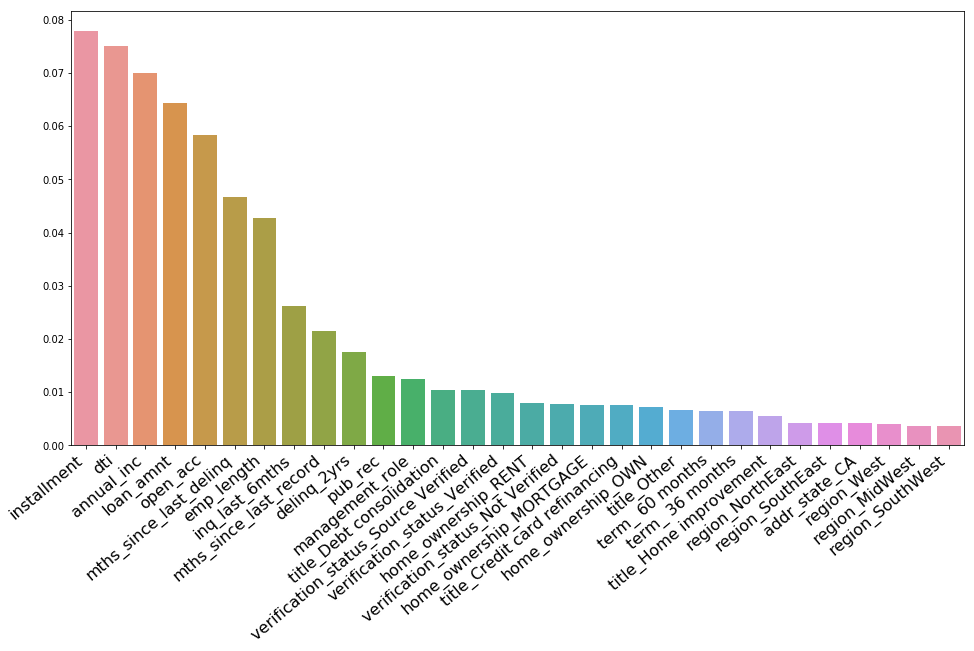

In [211]:
plt.figure(figsize=(16,8))
s=sns.barplot(x=X.columns[idxs],y=fi[idxs])
s.set_xticklabels(s.get_xticklabels(), rotation=40, ha="right",size=16)

### Final model

not final model, just something to enable you guys to continue the work

I'll finalize the data in a day or so :)

# Prediction - Default Probability 

In [457]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [458]:
pred = logreg.predict(X_test)
pred_prob = logreg.predict_proba(X_test)

In [463]:
print(pred.shape)
pred

(96779,)


array([0, 0, 0, ..., 0, 0, 0])

In [464]:
print(pred_prob.shape)
pred_prob

(96779, 2)


array([[0.99389425, 0.00610575],
       [0.88548028, 0.11451972],
       [0.96155822, 0.03844178],
       ...,
       [0.82921023, 0.17078977],
       [0.90917496, 0.09082504],
       [0.82201284, 0.17798716]])

In [465]:
np.savetxt('default_probabilities.csv',pred_prob)